[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TAZIM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
g:\Topic Modeling Project\venv\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_lg' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.6). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Starting NMF topic modeling pipeline...
Loaded 2225 rows. Using text column: content
Columns: ['category', 'filename', 'title', 'content']
Cleaning raw text...
Lemmatizing with spaCy (this can take a while)...
Building bigrams/trigrams...
Dictionary size after filtering: 5834

=== TF-IDF max_features = 2000 ===
TF-IDF shape: (2225, 2000)
Training NMF: topics=4, params={'beta_loss': 'frobenius', 'alpha_W': 0.0, 'alpha_H': 0.0, 'l1_ratio': 0.0}
--> Coherence (c_v): 0.6773
Training NMF: topics=5, params={'beta_loss': 'frobenius', 'alpha_W': 0.0, 'alpha_H': 0.0, 'l1_ratio': 0.0}
--> Coherence (c_v): 0.7123
Training NMF: topics=6, params={'beta_loss': 'frobenius', 'alpha_W': 0.0, 'alpha_H': 0.0, 'l1_ratio': 0.0}
--> Coherence (c_v): 0.6960
Training NMF: topics=7, params={'beta_loss': 'frobenius', 'alpha_W': 0.0, 'alpha_H': 0.0, 'l1_ratio': 0.0}
--> Coherence (c_v): 0.7026
Training NMF: topics=8, params={'beta_loss': 'frobenius', 'alpha_W': 0.0, 'alpha_H': 0.0, 'l1_ratio': 0.0}
--> Coherence

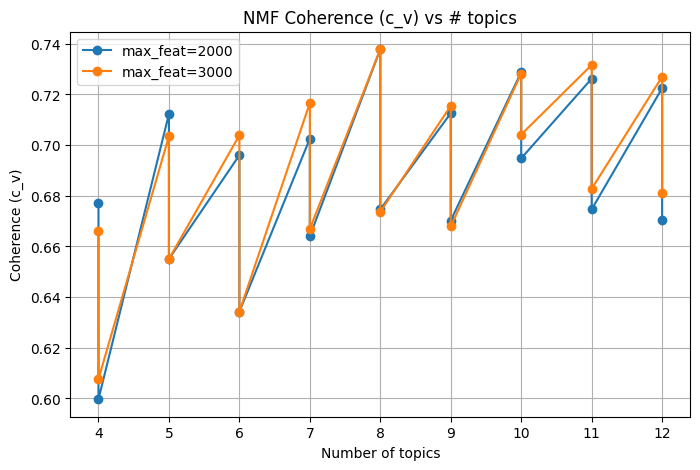


Top words per topic (best model):
Topic 1: use, people, user, technology, mobile, phone, service, software, computer, network, net, site, broadband, system, program


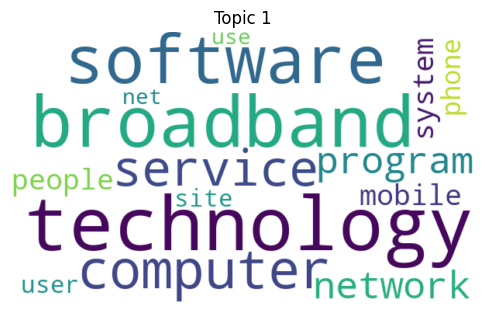

Topic 2: win, play, match, player, side, team, good, get, season, final, beat, injury, time, club, back


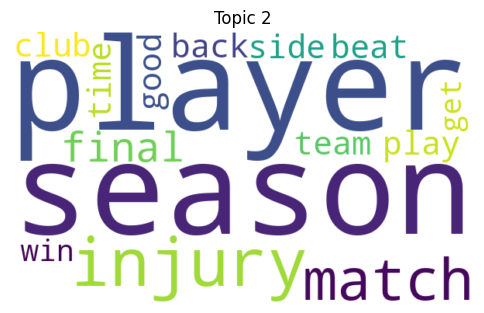

Topic 3: film, award, good, actor, star, actress, director, win, movie, oscar, role, festival, include, aviator, nomination


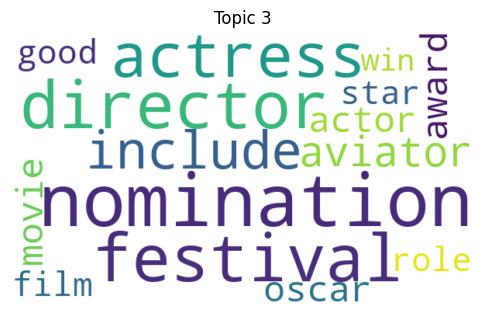

Topic 4: labour, party, election, government, tory, plan, people, conservative, tell, public, tax, chancellor, prime_minister, claim, leader


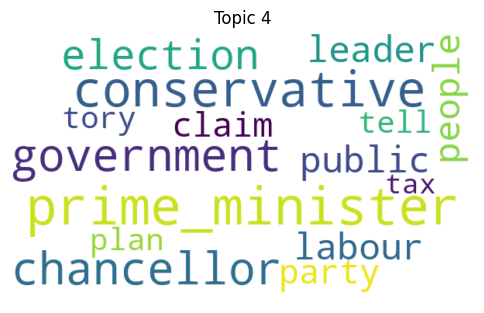

Topic 5: economy, rise, growth, fall, figure, rate, dollar, month, price, economic, export, interest_rate, high, market, sale


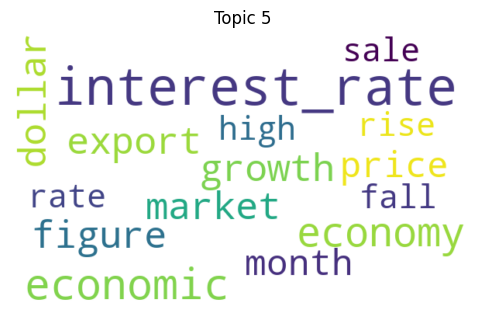

Topic 6: company, firm, share, deal, sale, yukos, bid, business, buy, sell, offer, shareholder, profit, club, market


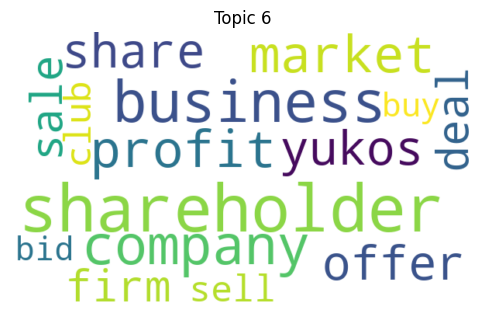

Topic 7: music, album, band, song, chart, number, single, record, top, singer, release, show, artist, include, award


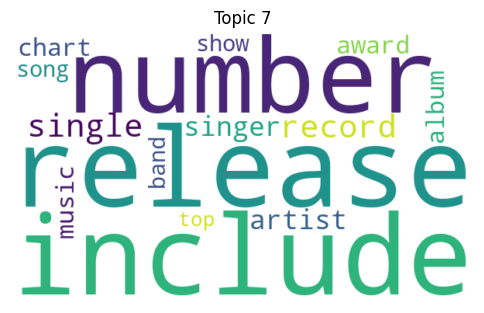

Topic 8: game, console, player, play, gamer, video game, video, title, gaming, release, nintendo, sale, developer, halo, machine


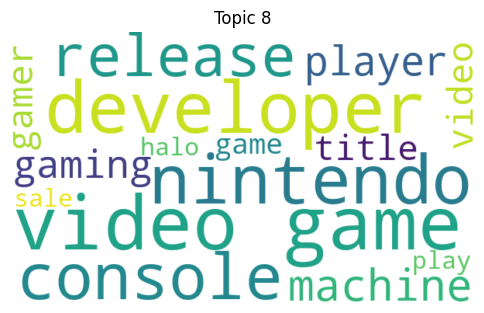


Assigning dominant topic to documents...
Saved document-topic assignments to nmf_results/documents_with_topics.csv

Pipeline completed successfully!
Results saved to: nmf_results
Document-topic assignments saved to: nmf_results\documents_with_topics.csv


In [4]:
# nmf_improved_pipeline.py
import re
import os
import json
import joblib
from tqdm import tqdm
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy
from nltk.corpus import stopwords
import nltk
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from wordcloud import WordCloud

nltk.download("stopwords")
nlp = spacy.load("en_core_web_lg", disable=["ner", "parser"])  # heavy model for good lemmatization

# ---------------------------
# Utilities & Preprocessing
# ---------------------------
NEWS_STOPWORDS = {
    "said","say","mr","mrs","ms","one","two","new","news","bbc","also",
    "would","could","like","year","years","today","last","first","may","told",
    "reuters","report","reports","said","u","s","us"
}

# Cleaner function
def clean_text_raw(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"https?://\S+|www\.\S+", "", text)     # URLs
    text = re.sub(r"\S+@\S+", "", text)                   # emails
    text = re.sub(r"[^a-z\s]", " ", text)                 # non-letters
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Full preprocessing: lemmatize & POS filter
def spacy_lemmatize(texts, allowed_pos={"NOUN","ADJ","VERB","ADV"}, batch_size=50):
    stop_words = set(stopwords.words("english")).union(NEWS_STOPWORDS)
    tokenized = []
    for doc in nlp.pipe(texts, batch_size=batch_size):
        toks = []
        for token in doc:
            if token.is_alpha and (token.pos_ in allowed_pos):
                lemma = token.lemma_.strip()
                if lemma and lemma not in stop_words and len(lemma) > 2:
                    toks.append(lemma)
        tokenized.append(toks)
    return tokenized

# Build bigrams/trigrams
def make_ngrams(tokenized_texts, min_count=5, threshold=50):
    bigram = Phrases(tokenized_texts, min_count=min_count, threshold=threshold)
    trigram = Phrases(bigram[tokenized_texts], threshold=threshold)
    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)
    texts_bi = [bigram_mod[doc] for doc in tokenized_texts]
    texts_tri = [trigram_mod[bigram_mod[doc]] for doc in texts_bi]
    return texts_tri, bigram_mod, trigram_mod

# Convert token lists to joined strings (for TF-IDF)
def join_tokens(texts):
    return [" ".join(t) for t in texts]

# Extract top words for an NMF component
def top_words_from_components(H, feature_names, topn=12):
    topics = []
    for topic_idx, topic in enumerate(H):
        top_indices = topic.argsort()[:-topn-1:-1]
        topics.append([feature_names[i] for i in top_indices])
    return topics

# Wordcloud for a list of words (weights optional)
def plot_wordcloud(words, title=None, savepath=None):
    # words can be list or dict (word->weight)
    if isinstance(words, list):
        freq = {w: (len(w) + 1) for w in words}  # naive weight
    elif isinstance(words, dict):
        freq = words
    else:
        freq = {w: 1 for w in words}
    wc = WordCloud(width=600, height=350, background_color="white").generate_from_frequencies(freq)
    plt.figure(figsize=(6,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    if title:
        plt.title(title)
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()

# ---------------------------
# Main pipeline
# ---------------------------
def run_nmf_pipeline(
    csv_path=r"G:\Topic Modeling Project\artifacts\bbc-news-data.csv",
    text_col="content",
    out_dir="nmf_results",
    test_run_docs=None,
    tfidf_max_features_options=[2000, 3000],
    n_topic_range=range(4,13),
    nmf_kwargs_grid=[{"beta_loss":"frobenius","alpha_W":0.0,"alpha_H":0.0,"l1_ratio":0.0},
                     {"beta_loss":"kullback-leibler","solver":"mu","alpha_W":0.0,"alpha_H":0.0,"l1_ratio":0.0}]
):
    os.makedirs(out_dir, exist_ok=True)
    # Read CSV with tab delimiter and handle potential parsing issues
    try:
        # Try with newer pandas syntax first
        df = pd.read_csv(csv_path, sep='\t', on_bad_lines='skip', quoting=3)  # quoting=3 for QUOTE_NONE
    except TypeError:
        # Fall back to older pandas syntax
        try:
            df = pd.read_csv(csv_path, sep='\t', error_bad_lines=False, warn_bad_lines=True)
        except Exception as e:
            print(f"Error reading CSV: {e}")
            # Last resort: read line by line and parse manually
            print("Reading file line by line...")
            import csv
            data = []
            with open(csv_path, 'r', encoding='utf-8') as f:
                reader = csv.reader(f, delimiter='\t')
                header = next(reader)
                for i, row in enumerate(reader):
                    if len(row) >= 4:  # Ensure we have at least 4 columns
                        data.append(row[:4])  # Take only first 4 columns
                    if i > 10000:  # Limit for testing
                        break
            df = pd.DataFrame(data, columns=header[:4])
    
    print(f"Loaded {len(df)} rows. Using text column: {text_col}")
    print(f"Columns: {list(df.columns)}")

    # 1. Raw cleaning
    print("Cleaning raw text...")
    df["clean_raw"] = df[text_col].astype(str).apply(clean_text_raw)
    docs = df["clean_raw"].tolist()
    if test_run_docs:
        docs = docs[:test_run_docs]
        print(f"Test run with first {test_run_docs} documents")

    # 2. Lemmatize + pos filtering (spaCy)
    print("Lemmatizing with spaCy (this can take a while)...")
    tokenized = spacy_lemmatize(docs)

    # 3. Bigram/trigram
    print("Building bigrams/trigrams...")
    texts_ngram, bigram_mod, trigram_mod = make_ngrams(tokenized, min_count=5, threshold=50)

    # 4. Dictionary for coherence (gensim)
    dictionary = Dictionary(texts_ngram)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    print(f"Dictionary size after filtering: {len(dictionary)}")

    # Prepare texts for coherence (list of token lists)
    texts_for_coherence = texts_ngram

    # 5. Try variant TF-IDF max_features and NMF hyperparams -> evaluate coherence
    best = {"coherence": -999, "params": None, "model": None, "vectorizer": None, "H": None, "W": None, "tfidf_matrix": None}
    results = []
    for max_features in tfidf_max_features_options:
        print(f"\n=== TF-IDF max_features = {max_features} ===")
        tfidf = TfidfVectorizer(
            max_df=0.95, min_df=2, max_features=max_features,
            stop_words=None, ngram_range=(1,2)
        )
        joined_texts = join_tokens(texts_ngram)
        X = tfidf.fit_transform(joined_texts)
        feature_names = tfidf.get_feature_names_out()
        print(f"TF-IDF shape: {X.shape}")

        for nmf_kw in nmf_kwargs_grid:
            for n_topics in n_topic_range:
                print(f"Training NMF: topics={n_topics}, params={nmf_kw}")
                # create NMF with given params - filter valid parameters
                valid_nmf_params = {}
                for k, v in nmf_kw.items():
                    if k in ['beta_loss', 'solver', 'alpha_W', 'alpha_H', 'l1_ratio']:
                        valid_nmf_params[k] = v
                
                nmf = NMF(n_components=n_topics, random_state=42, init="nndsvda", max_iter=400, **valid_nmf_params)
                W = nmf.fit_transform(X)
                H = nmf.components_
                # Extract top words, build gensim topics format
                top_words = top_words_from_components(H, feature_names, topn=12)

                # Build a gensim coherence model
                cm = CoherenceModel(topics=top_words, texts=texts_for_coherence, dictionary=dictionary, coherence="c_v")
                coherence = cm.get_coherence()
                print(f"--> Coherence (c_v): {coherence:.4f}")

                results.append({
                    "max_features": max_features,
                    "nmf_params": nmf_kw,
                    "n_topics": n_topics,
                    "coherence": coherence,
                    "model": nmf,
                    "W": W,
                    "H": H,
                    "tfidf": tfidf
                })

                # Track best
                if coherence > best["coherence"]:
                    best.update({
                        "coherence": coherence,
                        "params": {"max_features": max_features, "nmf_params": nmf_kw, "n_topics": n_topics},
                        "model": nmf,
                        "H": H,
                        "W": W,
                        "tfidf_matrix": X,
                        "vectorizer": tfidf,
                        "feature_names": feature_names
                    })

    # 6. Summary of best model
    print("\n=== Best model summary ===")
    pprint(best["params"])
    print(f"Best coherence: {best['coherence']:.4f}")

    # Save best artifacts
    joblib.dump(best["model"], os.path.join(out_dir, "best_nmf_model.joblib"))
    joblib.dump(best["vectorizer"], os.path.join(out_dir, "best_tfidf_vectorizer.joblib"))
    with open(os.path.join(out_dir, "best_params.json"), "w") as f:
        json.dump(best["params"], f, indent=2)
    print(f"Saved best model & vectorizer to {out_dir}")

    # 7. Plot coherence vs topics (from results)
    df_res = pd.DataFrame([{"n_topics": r["n_topics"], "coherence": r["coherence"], "max_features": r["max_features"], "beta_loss": r["nmf_params"].get("beta_loss", "")} for r in results])
    plt.figure(figsize=(8,5))
    for mf in df_res["max_features"].unique():
        subset = df_res[df_res["max_features"]==mf]
        subset = subset.sort_values("n_topics")
        plt.plot(subset["n_topics"], subset["coherence"], marker="o", label=f"max_feat={mf}")
    plt.xlabel("Number of topics")
    plt.ylabel("Coherence (c_v)")
    plt.title("NMF Coherence (c_v) vs # topics")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(out_dir, "coherence_vs_topics.png"))
    plt.show()

    # 8. Print & plot top words and wordclouds for best model
    best_H = best["H"]
    best_feature_names = best["feature_names"]
    best_n = best["params"]["n_topics"]
    topics = top_words_from_components(best_H, best_feature_names, topn=15)
    print("\nTop words per topic (best model):")
    for i, twords in enumerate(topics, 1):
        print(f"Topic {i}: {', '.join(twords)}")
        plot_wordcloud(twords, title=f"Topic {i}", savepath=os.path.join(out_dir, f"topic_{i}_wordcloud.png"))

    # 9. Assign dominant topic to each document & save
    print("\nAssigning dominant topic to documents...")
    W_best = best["W"]
    dominant = np.argmax(W_best, axis=1)
    # If we used test_run_docs, only a subset was processed. Align lengths.
    df_out = df.copy().iloc[:len(dominant)].reset_index(drop=True)
    df_out["dominant_topic"] = dominant
    df_out.to_csv(os.path.join(out_dir, "documents_with_topics.csv"), index=False)
    print(f"Saved document-topic assignments to {out_dir}/documents_with_topics.csv")

    return best, results, os.path.join(out_dir, "documents_with_topics.csv")

# ---------------------------
# Run the pipeline directly in notebook
# ---------------------------
# Run the NMF pipeline with default parameters
# You can modify these parameters as needed
csv_path = r"G:\Topic Modeling Project\artifacts\bbc-news-data.csv"
output_dir = "nmf_results"
test_docs = None  # Set to a small number like 100 for quick testing

print("Starting NMF topic modeling pipeline...")
best_model, results, output_file = run_nmf_pipeline(
    csv_path=csv_path,
    out_dir=output_dir,
    test_run_docs=test_docs
)

print(f"\nPipeline completed successfully!")
print(f"Results saved to: {output_dir}")
print(f"Document-topic assignments saved to: {output_file}")
 